# Insightface

In [1]:
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt

import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image

In [2]:
print('insightface', insightface.__version__)
print('numpy', np.__version__)

insightface 0.7.3
numpy 1.24.3


## Step 1. Detect Faces

In [7]:
app = FaceAnalysis(name='buffalo_l')
app.prepare(ctx_id=0, det_size=(640, 640))

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/robmulla/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/robmulla/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/robmulla/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/robmulla/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/robmulla/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.

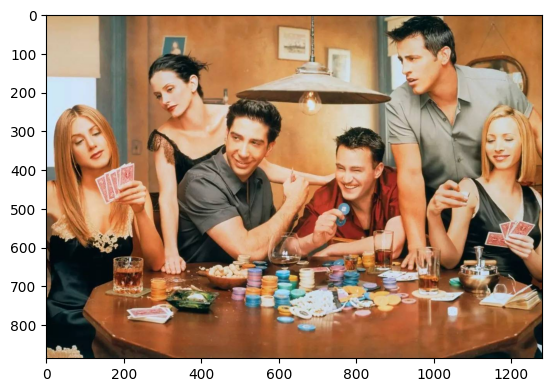

In [9]:
img = ins_get_image('t1')
plt.imshow(img[:,:,::-1])
plt.show()

In [10]:
faces =app.get(img)

/home/robmulla/anaconda3/envs/insight/lib/python3.9/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


## Crop and plot Faces

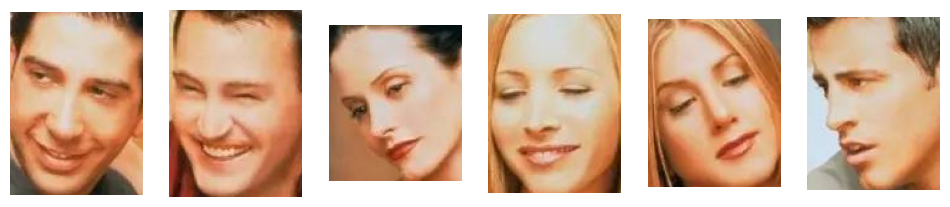

In [22]:
img = ins_get_image('t1')
fig, axs = plt.subplots(1, 6, figsize=(12, 5))

for i, face in enumerate(faces):
    bbox = face['bbox']
    bbox = [int(b) for b in bbox]
    axs[i].imshow(img[bbox[1]:bbox[3],bbox[0]:bbox[2],::-1])
    axs[i].axis('off')    

# Step 2. Face Swapping

In [23]:
swapper = insightface.model_zoo.get_model('inswapper_128.onnx',
                                download=False,
                                download_zip=False)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
inswapper-shape: [1, 3, 128, 128]


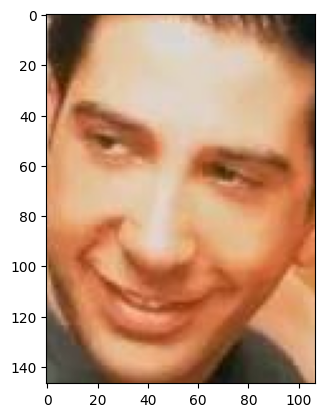

In [28]:
source_face = faces[0]
bbox = source_face['bbox']
bbox = [int(b) for b in bbox]
plt.imshow(img[bbox[1]:bbox[3],bbox[0]:bbox[2],::-1])
plt.show()

In [29]:
res = img.copy()
for face in faces:
    res = swapper.get(res, face, source_face, paste_back=True)

## Plot the Swapped Faces

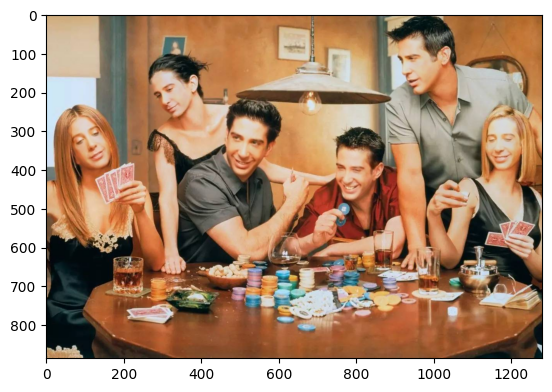

In [30]:
plt.imshow(res[:,:,::-1])
plt.show()

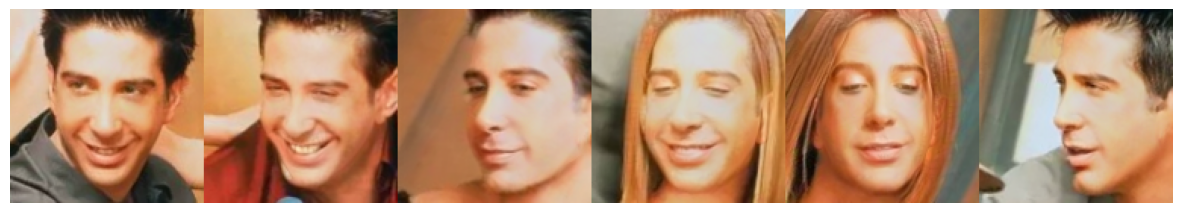

In [33]:
res = []
for face in faces:
    _img, _ = swapper.get(img, face, source_face, paste_back=False)
    res.append(_img)
res = np.concatenate(res, axis=1)
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(res[:,:,::-1])
ax.axis('off')
plt.show()

# Swap in my Face

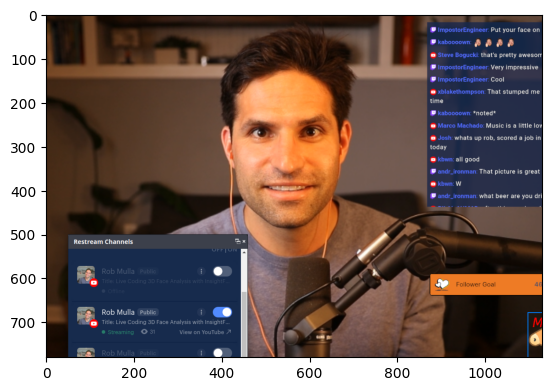

In [35]:
rob = cv2.imread('Screenshot from 2023-06-06 22-30-10.png')
plt.imshow(rob[:,:,::-1])
plt.show()

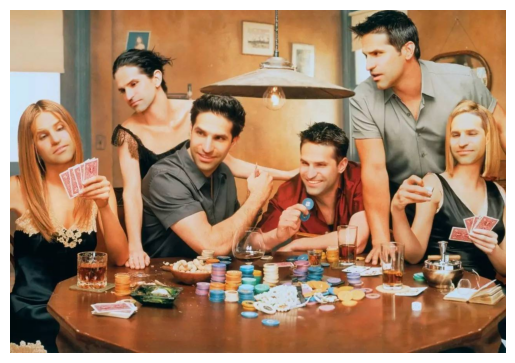

In [38]:
# Detect the Face
rob_faces = app.get(rob)
rob_face = rob_faces[0]
# Replace faces in friends image
res = img.copy()
for face in faces:
    res = swapper.get(res, face, rob_face, paste_back=True)

fig, ax = plt.subplots()
ax.imshow(res[:,:,::-1])
ax.axis('off')
plt.show() 

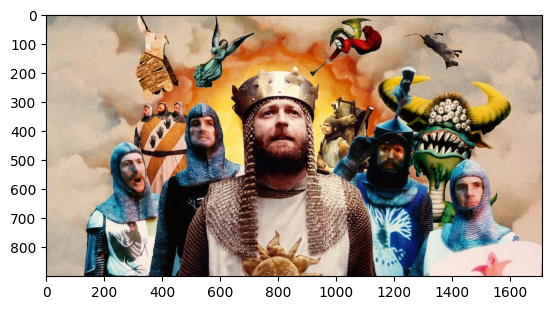

In [39]:
monty = cv2.imread('Monty-Python-and-the-Holy-Grail.jpg')
plt.imshow(monty[:,:,::-1])
plt.show()

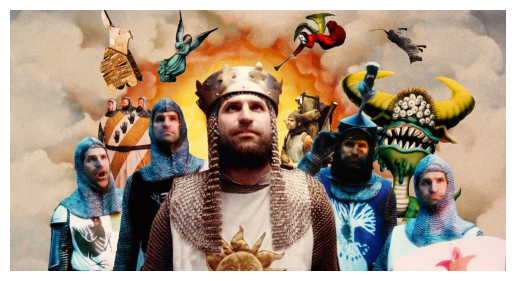

In [40]:
faces = app.get(monty)
res = monty.copy()
for face in faces:
    res = swapper.get(res, face, rob_face, paste_back=True)
fig, ax = plt.subplots()
ax.imshow(res[:,:,::-1])
ax.axis('off')
plt.show() 

# Swap Faces from Two Images

In [41]:
def swap_n_show(img1_fn,
                img2_fn,
                app,
                swapper,
                plot_before=True,
                plot_after=True):
    """
    Uses face swapper to swap faces in two different images.
    
    plot_before: if True shows the images before the swap
    plot_after: if True shows the images after the swap
    
    returns images with swapped faces.
    
    Assumes one face per image.
    """
    img1 = cv2.imread(img1_fn)
    img2 = cv2.imread(img2_fn)
    
    if plot_before:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(img1[:,:,::-1])
        axs[0].axis('off')
        axs[1].imshow(img2[:,:,::-1])
        axs[1].axis('off')
        plt.show()
    
    # Do the swap
    face1 = app.get(img1)[0]
    face2 = app.get(img2)[0]
    
    img1_ = img1.copy()
    img2_ = img2.copy()
    if plot_after:
        img1_ = swapper.get(img1_, face1, face2, paste_back=True)
        img2_ = swapper.get(img2_, face2, face1, paste_back=True)
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(img1_[:,:,::-1])
        axs[0].axis('off')
        axs[1].imshow(img2_[:,:,::-1])
        axs[1].axis('off')
        plt.show()
    return img1_, img2_

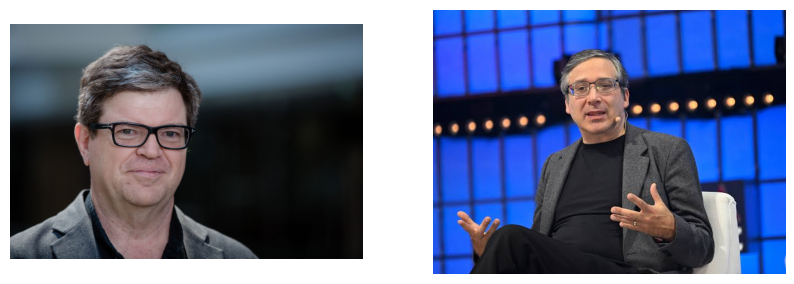

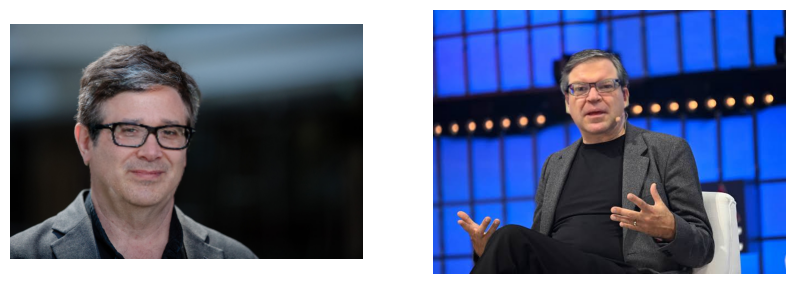

In [43]:
_ = swap_n_show('lecun.jpeg', 'gary.jpeg', app, swapper)

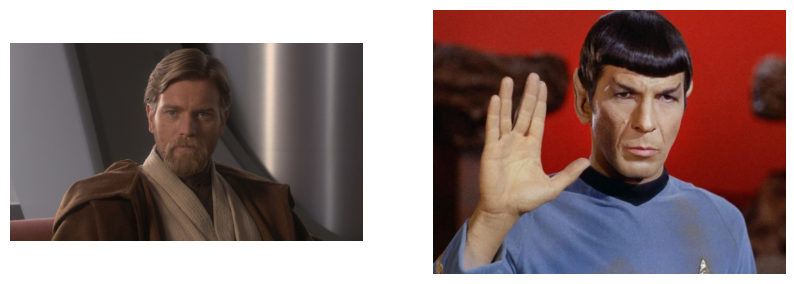

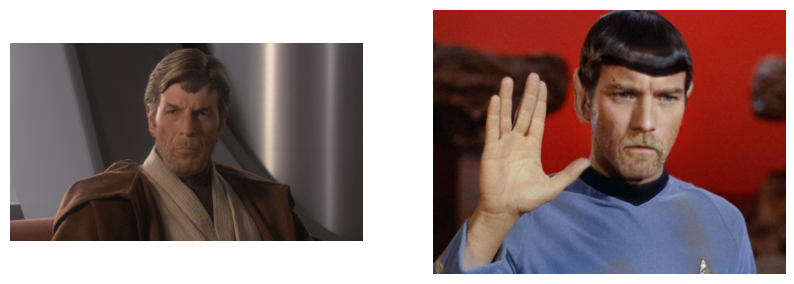

In [44]:
_ = swap_n_show('obi-wan.jpeg', 'spock.jpg', app, swapper)

# Swap Faces from Same Image

In [45]:
def swap_n_show_same_img(img1_fn,
                         app,
                         swapper,
                         plot_before=True,
                         plot_after=True):
    """
    Uses face swapper to swap faces in the same image.
    
    plot_before: if True shows the images before the swap
    plot_after: if True shows the images after the swap
    
    returns images with swapped faces.
    
    Assumes one face per image.
    """
    img1 = cv2.imread(img1_fn)
    
    if plot_before:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax.imshow(img1[:,:,::-1])
        ax.axis('off')
        plt.show()
    
    # Do the swap
    faces = app.get(img1)
    face1, face2 = faces[0], faces[1]
    
    img1_ = img1.copy()
    if plot_after:
        img1_ = swapper.get(img1_, face1, face2, paste_back=True)
        img1_ = swapper.get(img1_, face2, face1, paste_back=True)
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax.imshow(img1_[:,:,::-1])
        ax.axis('off')
        plt.show()
    return img1_

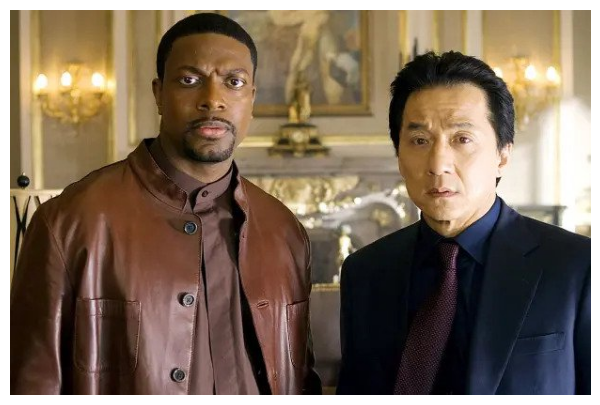

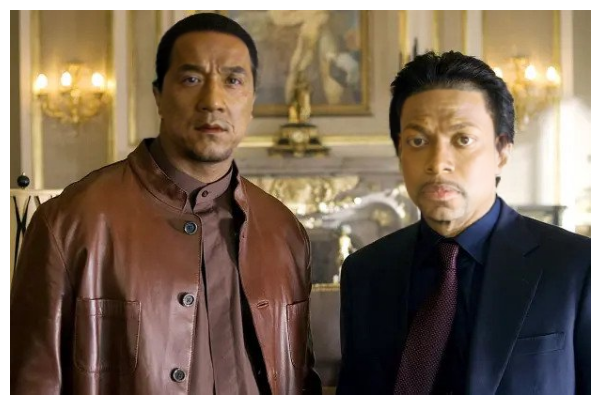

In [46]:
_ = swap_n_show_same_img('rush-hour.jpg', app, swapper)

In [47]:
from glob import glob
couples = glob('couple*')

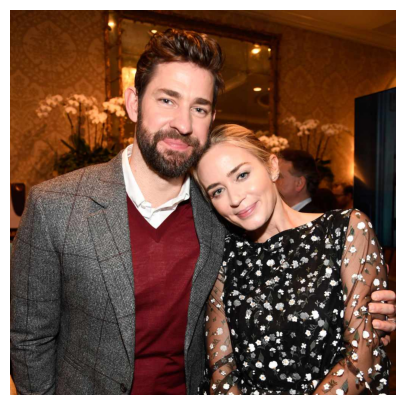

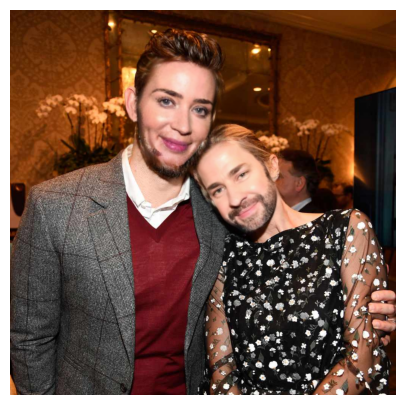

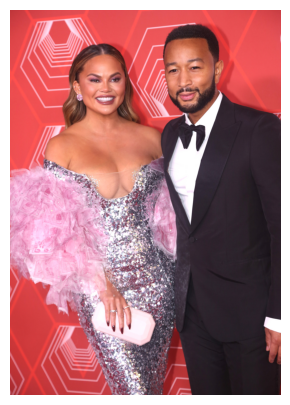

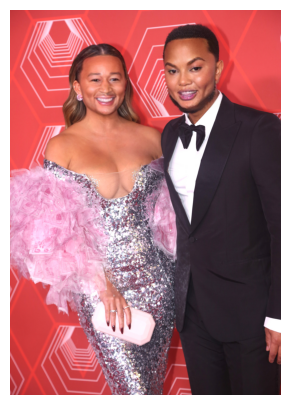

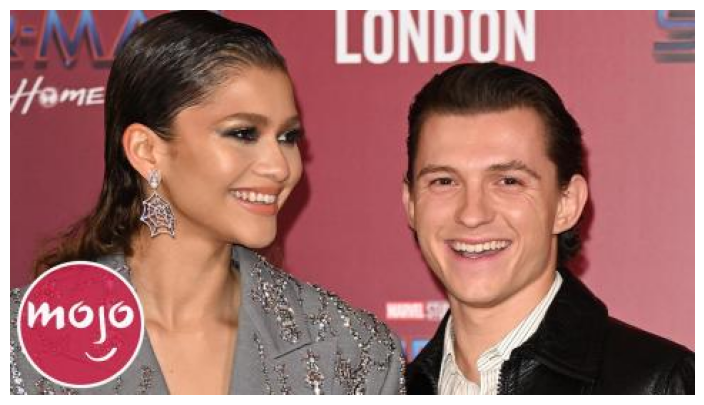

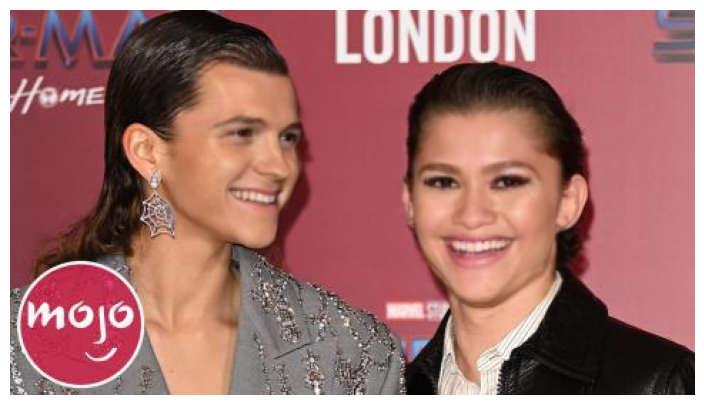

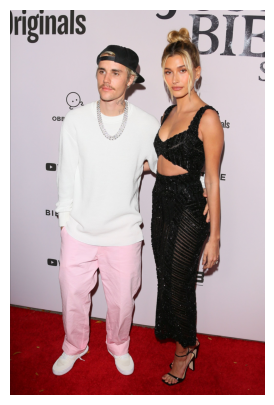

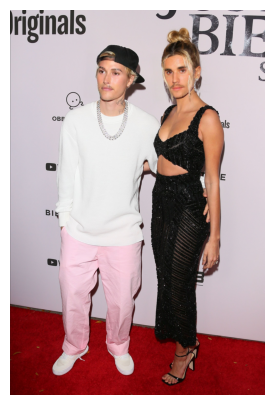

In [48]:
for couple in couples:
    _ = swap_n_show_same_img(couple, app, swapper)